# Working out what Pre-Processing method to do

In [1]:
# Imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import os
import json
import pandas as pd
import cv2 as cv
from skimage import exposure
import sys
sys.path.append('../..')
from src.utils import *
from src.skmtea_utils import *

/Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <5324ABF2-35BD-359C-98AF-57A0CB18B6E8> /Users/olivermills/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <73F684F2-E1D9-32A8-B2A3-4E00185FE48E> /Users/olivermills/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


## Read In Images and Check Statistics

In [2]:
# Paths
image_dir_path = '../../../qdess/v1-release/image_files/'
ann_dir_path = '../../../qdess/v1-release/annotations/v1.0.0/'
pred_path = '../../../unet_mask_predictions_val'
save_path = '../../../' # outside of the repo
oai_dir_path = '../../data/test_OAI_im/dicom_series/'
iwoai_dir_path = '../../data/IWOAI/train/'

In [3]:
# Path to the JSON file
file_path = "train.json"

# Open and load the JSON file
with open(ann_dir_path + file_path, "r") as file:
    data = json.load(file)

# Access each part of the JSON structure
info = data["info"]
categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

# get paths from image data
ims_df = pd.DataFrame(images)
image_paths = ims_df['file_name'].to_numpy()

In [4]:
# make dataframe to store values
rows = []

# Load in both echos of first 10 images. Print mean, std, and max values of each echo, as well as for rss.
for path in image_paths[:10]:
    echo1, echo2 = get_skmtea_both_echos(path, image_dir_path)
    rss = RSS(echo1, echo2)
    print(f"Image: {path}")
    print(f"Echo 1: Mean = {echo1.mean()}, Std = {echo1.std()}, Max = {echo1.max()}")
    print(f"Echo 2: Mean = {echo2.mean()}, Std = {echo2.std()}, Max = {echo2.max()}")
    print(f"RSS: Mean = {rss.mean()}, Std = {rss.std()}, Max = {rss.max()}")
    print("\n")

    # Collect data as a dictionary
    rows.append({
        'image': path,
        'echo1_mean': echo1.mean(),
        'echo1_std': echo1.std(),
        'echo1_max': echo1.max(),
        'echo2_mean': echo2.mean(),
        'echo2_std': echo2.std(),
        'echo2_max': echo2.max(),
        'rss_mean': rss.mean(),
        'rss_std': rss.std(),
        'rss_max': rss.max()
    })

# Convert the dictionary to a dataframe
stats_df = pd.DataFrame(rows)


Image: MTR_001.h5
Echo 1: Mean = 1674.2886671543122, Std = 1512.1253585106253, Max = 17891.0
Echo 2: Mean = 789.4608332872391, Std = 502.75437039430193, Max = 13279.0
RSS: Mean = 1893.5161345106983, Std = 1542.84563498915, Max = 19425.830741566755


Image: MTR_008.h5
Echo 1: Mean = 573.3287077188492, Std = 585.3940422058218, Max = 5451.0
Echo 2: Mean = 253.5943624019623, Std = 197.47127036207465, Max = 4716.0
RSS: Mean = 641.7219761587082, Std = 602.4034365108389, Max = 6772.020082663666


Image: MTR_010.h5
Echo 1: Mean = 530.1854779481888, Std = 574.7082334591929, Max = 4810.0
Echo 2: Mean = 207.6363209247589, Std = 142.14008888930533, Max = 4059.0
RSS: Mean = 583.60010199186, Std = 578.0257452957059, Max = 6196.833788314803


Image: MTR_015.h5
Echo 1: Mean = 374.9925535917282, Std = 485.86381213680045, Max = 4304.0
Echo 2: Mean = 190.74682946205138, Std = 213.81322946741116, Max = 3708.0
RSS: Mean = 432.60482101472127, Std = 521.1876610907798, Max = 5501.596949977343


Image: MTR_016

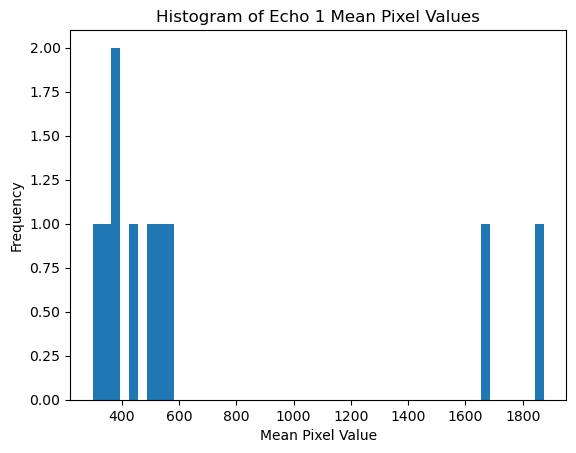

In [5]:
# plot hist of echo1 means
plt.hist(stats_df['echo1_mean'], bins=50)
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Echo 1 Mean Pixel Values')
plt.show()

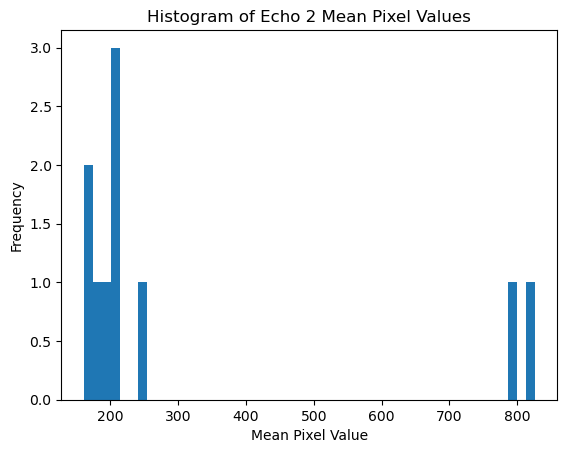

In [6]:
# plot hist of echo2 means
plt.hist(stats_df['echo2_mean'], bins=50)
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Echo 2 Mean Pixel Values')
plt.show()

# Compare Kernel Density Plots of final combined images using different methods

In [47]:
# Images 1 and 2 have very different means/stds, so let's overlap the kde of both
# then see how normalisation tackles this variation.

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

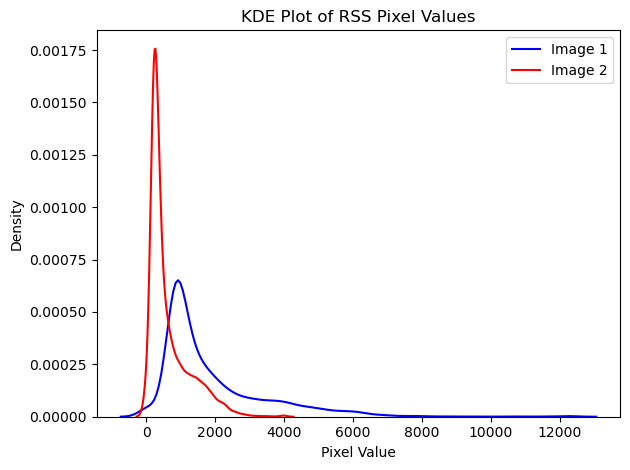

In [48]:
# plot kde plot of rss of first image
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
rss = RSS(echo1, echo2)
# clip to 99th percentile
rss = np.clip(rss, 0, np.percentile(rss, 99.9))
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
sns.kdeplot(rss_sample, label='Image 1', color='blue')

# plot kdo of image 2
echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
rss = RSS(echo1, echo2)
# clip to 99th percentile
rss = np.clip(rss, 0, np.percentile(rss, 99.9))
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
sns.kdeplot(rss_sample, label='Image 2', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of RSS Pixel Values')
plt.legend()
plt.tight_layout()

# save plot
plt.savefig(save_path + 'no_processing_rss_kde.png', dpi=300)
plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

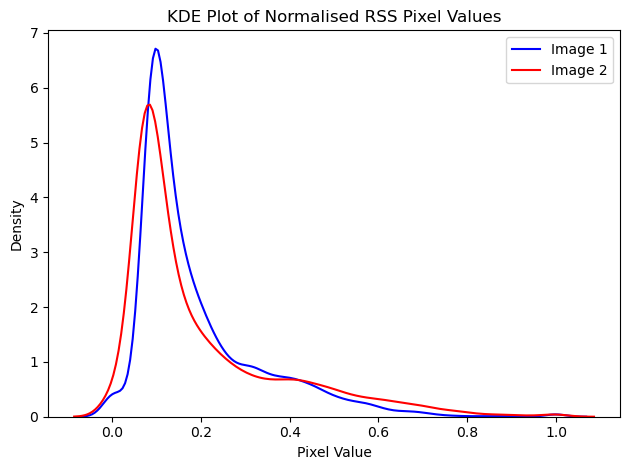

In [49]:
# Plot these two after normalisation method I've been previously doing
# of rescaling echos to 0-1, then taking RSS and clipping to 0.6
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Normalised RSS Pixel Values')
plt.legend()
plt.tight_layout()

# savefig
plt.savefig(save_path + 'kde_plot_prev_norm_method.png', dpi=300)

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

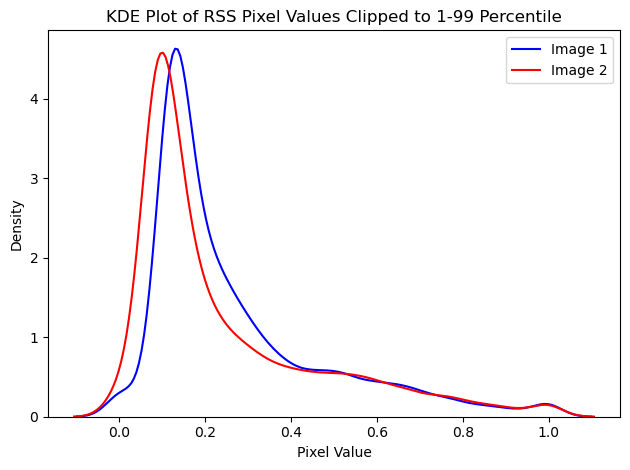

In [5]:
# Let's instead clip by percentile between 1 and 99
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = clip_and_norm(im1, np.percentile(im1, 1), np.percentile(im1, 99))
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = clip_and_norm(im2, np.percentile(im2, 1), np.percentile(im2, 99))
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of RSS Pixel Values Clipped to 1-99 Percentile')
plt.legend()
plt.tight_layout()

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

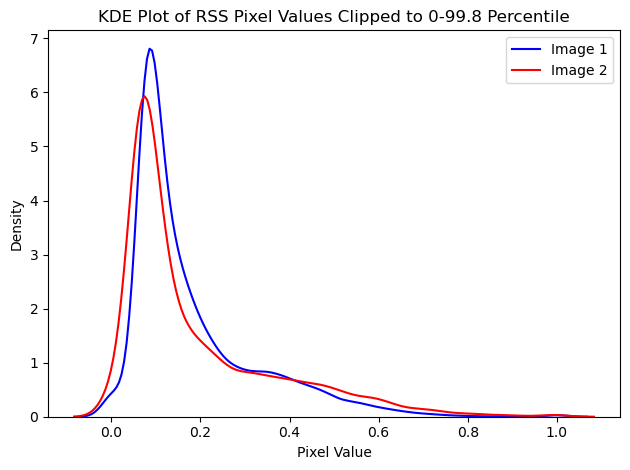

In [5]:
# Let's instead clip by percentile between 0 and 99.8
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = clip_and_norm(im1, 0, np.percentile(im1, 99.8))
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = clip_and_norm(im2, 0, np.percentile(im2, 99.8))
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of RSS Pixel Values Clipped to 0-99.8 Percentile')
plt.legend()
plt.tight_layout()

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

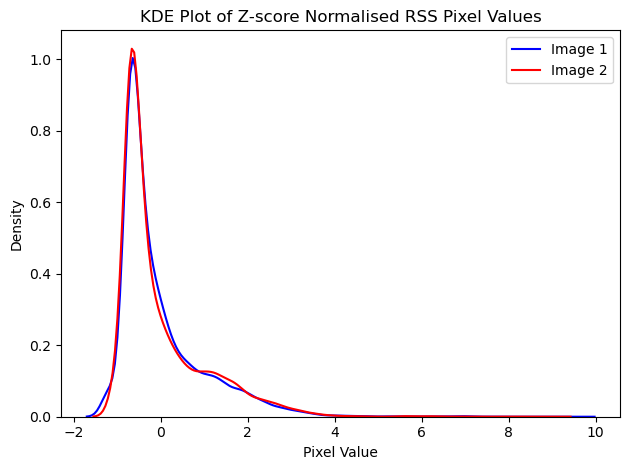

In [50]:
# instead, let's do z-score normalisation of the rss
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
rss = RSS(echo1, echo2)
rss = (rss - rss.mean()) / rss.std()
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
#rss_sample = np.clip(rss_sample, -3, 3)
sns.kdeplot(rss_sample, label='Image 1', color='blue')

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
rss = RSS(echo1, echo2)
rss = (rss - rss.mean()) / rss.std()
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
#rss_sample = np.clip(rss_sample, -3, 3)
sns.kdeplot(rss_sample, label='Image 2', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Z-score Normalised RSS Pixel Values')
plt.legend()
plt.tight_layout()

# savefig
plt.savefig(save_path + 'kde_plot_zscore_norm.png', dpi=300)

plt.show()

## Looks like z-score normalisation is a better method for closely mapping distributions, at least within this dataset.

# Let's now look at how these compare to an OAI Image

In [22]:
import SimpleITK as sitk
import os

# Use the ImageSeriesReader to read the DICOM series
reader = sitk.ImageSeriesReader()

# Get the list of file names for the DICOM series
dicom_series = reader.GetGDCMSeriesFileNames(oai_dir_path)

# Set the file names for the reader
reader.SetFileNames(dicom_series)

# Load the DICOM series as a 3D image
oai_image = reader.Execute()

# Get the numpy array from the 3D image
oai_array = sitk.GetArrayFromImage(oai_image)

# Get the shape of the array
print(oai_array.shape)


(160, 384, 384)


In [23]:
# reorder array to put slices back at the end
oai_array = np.moveaxis(oai_array, 0, -1)

In [4]:
# load iwoai image using h5py
im_path = iwoai_dir_path + 'train_001_V00.im'
with h5py.File(im_path, 'r') as f:
    iwoai_image = np.array(f['data'])

# get shape of the image
print(iwoai_image.shape)
oai_array = iwoai_image

(384, 384, 160)


/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


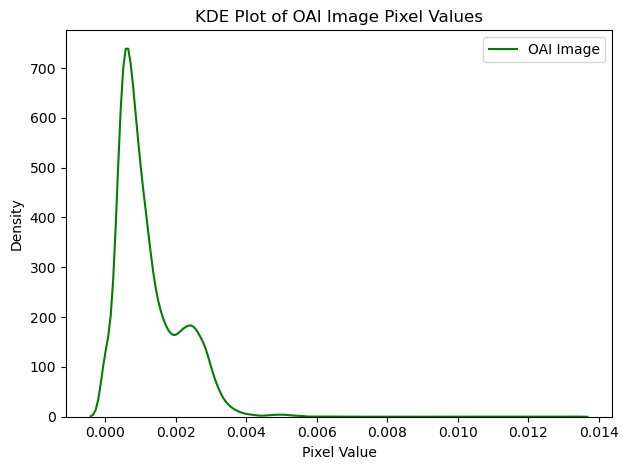

In [29]:
# plot kde of oai image
oai_sample = np.random.choice(oai_array.flatten(), size=10000, replace=False)
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of OAI Image Pixel Values')
plt.legend()
plt.tight_layout()

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

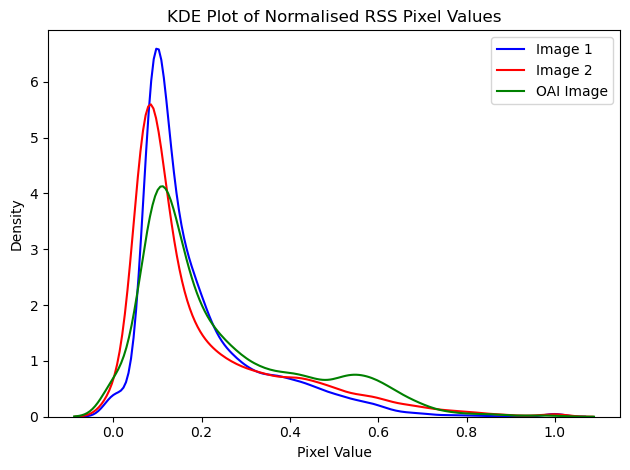

In [54]:
# clip this at 250 and scale to 0-1 (previous method) and compare
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

oai_array = clip_and_norm(oai_array, 250)
oai_sample = np.random.choice(oai_array.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Normalised RSS Pixel Values')
plt.legend()
plt.tight_layout()

# savefig
plt.savefig(save_path + 'kde_plot_prev_norm_method_with_oai.png', dpi=300)

plt.show()

## not terrible but note that this is an arbitrarily-chosen clip threshold so cannot account for variation in OAI data
## compare to percentile and z-score

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

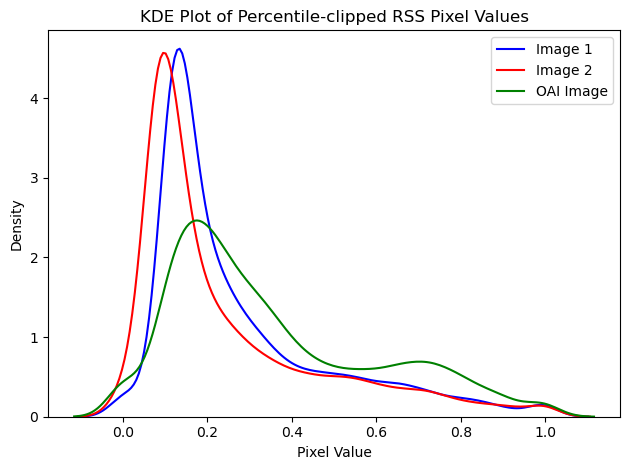

In [30]:
# clip at 1 and 99 percentiles and scale to 0-1
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = clip_and_norm(im1, np.percentile(im1, 1), np.percentile(im1, 99))
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = clip_and_norm(im2, np.percentile(im2, 1), np.percentile(im2, 99))
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

oai_array = clip_and_norm(oai_array, np.percentile(oai_array, 1), np.percentile(oai_array, 99))
oai_sample = np.random.choice(oai_array.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Percentile-clipped RSS Pixel Values')
plt.legend()
plt.tight_layout()

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

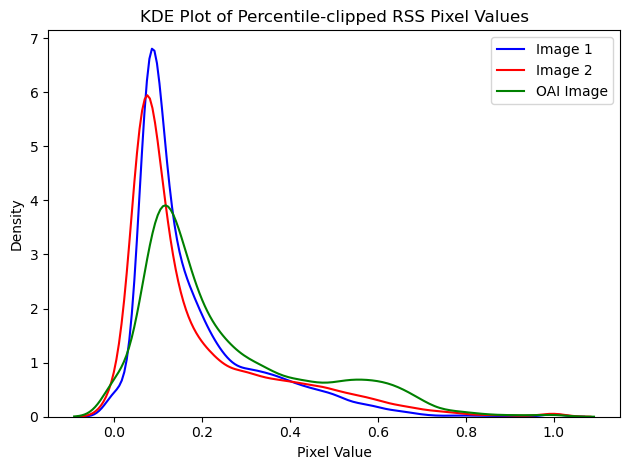

In [9]:
# clip at 0 and 99.8 percentiles and scale to 0-1
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
im1 = echo_combination(echo1, echo2)
im1 = clip_and_norm(im1, 0, np.percentile(im1, 99.8))
im1 = np.random.choice(im1.flatten(), size=10000, replace=False)

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
im2 = echo_combination(echo1, echo2)
im2 = clip_and_norm(im2, 0, np.percentile(im2, 99.8))
im2 = np.random.choice(im2.flatten(), size=10000, replace=False)

oai_array = clip_and_norm(oai_array, 0, np.percentile(oai_array, 99.8))
oai_sample = np.random.choice(oai_array.flatten(), size=10000, replace=False)

sns.kdeplot(im1, label='Image 1', color='blue')
sns.kdeplot(im2, label='Image 2', color='red')
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Percentile-clipped RSS Pixel Values')
plt.legend()
plt.tight_layout()

plt.show()

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

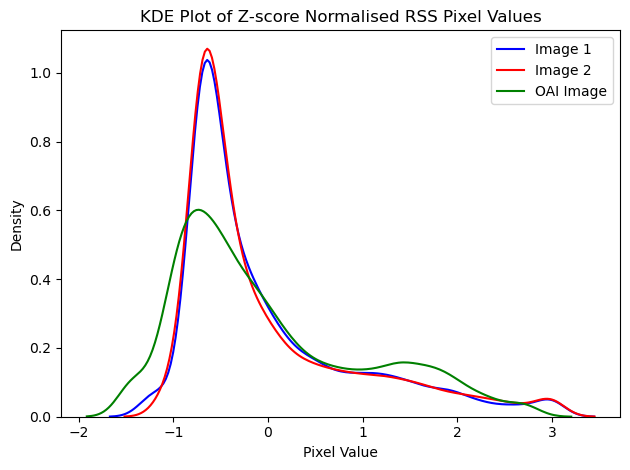

In [ ]:
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
rss = RSS(echo1, echo2)
rss = (rss - rss.mean()) / rss.std()
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
rss_sample = np.clip(rss_sample, -3, 3)
sns.kdeplot(rss_sample, label='Image 1', color='blue')

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
rss = RSS(echo1, echo2)
rss = (rss - rss.mean()) / rss.std()
rss_sample = np.random.choice(rss.flatten(), size=10000, replace=False)
rss_sample = np.clip(rss_sample, -3, 3)
sns.kdeplot(rss_sample, label='Image 2', color='red')

# z-score normalise the OAI image
oai_zscore = (oai_array - oai_array.mean()) / oai_array.std()
oai_sample = np.random.choice(oai_zscore.flatten(), size=10000, replace=False)
oai_sample = np.clip(oai_sample, -3, 3)
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Z-score Normalised RSS Pixel Values')
plt.legend()
plt.tight_layout()

# savefig
#plt.savefig(save_path + 'kde_plot_zscore_norm_with_oai.png', dpi=300)

plt.show()

# Now look at a couple other methods
## Histogram normalisation techniques

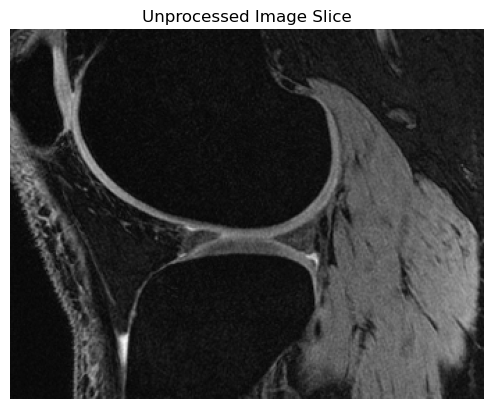

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

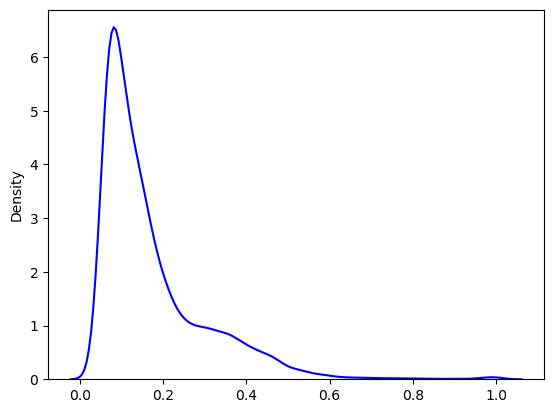

In [27]:
# Get unprocessed combined echo image and plot slice
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
image = skmtea_crop_im(echo_combination(echo1, echo2))
image = clip_and_norm(image, 0, np.percentile(image, 99.8)) # remove outliers and scale to 0-1

# plot slice
plt.imshow(image[..., 100], cmap='gray')
plt.axis('off')
plt.title('Unprocessed Image Slice')
plt.show();

# plot unprocessed image kde
image_sample = np.random.choice(image.flatten(), size=10000, replace=False)
sns.kdeplot(image_sample, color='blue')

In [15]:
print(image.shape)

(266, 341, 160)


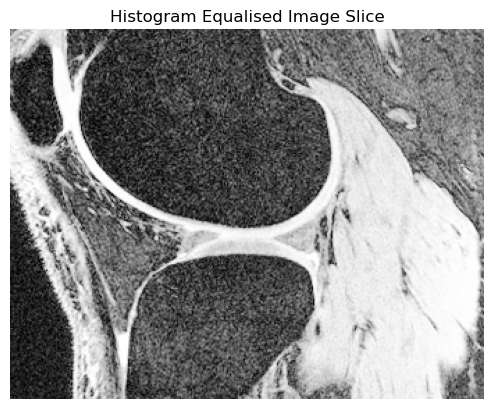

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


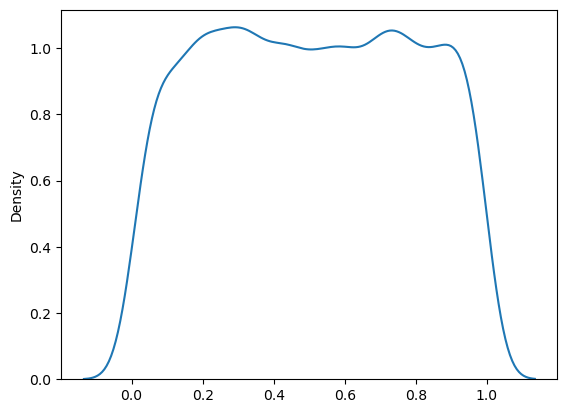

In [10]:
# Histogram equalisation using scikit-image
image_eq = exposure.equalize_hist(image)
plt.imshow(image_eq[..., 100], cmap='gray')
plt.axis('off')
plt.title('Histogram Equalised Image Slice')
plt.show();

# plot histogram of equalised image
eq_sample = np.random.choice(image_eq.flatten(), size=10000, replace=False)
sns.kdeplot(eq_sample)
plt.show();

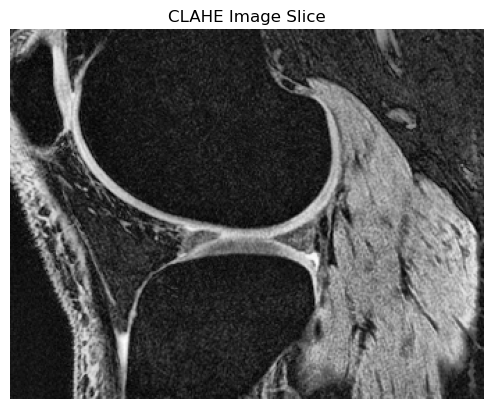

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

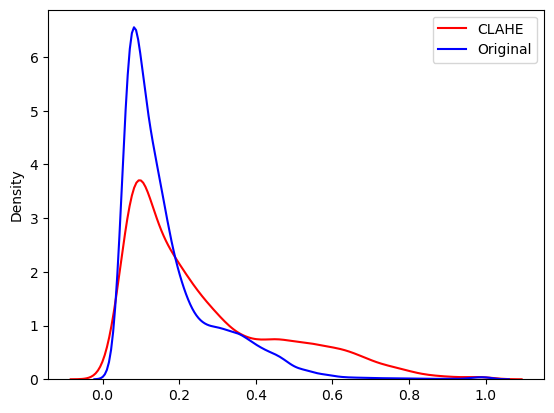

In [31]:
# clahe using scikit-image
# kernal size is 1/10th of the image size
kernel_size = (image.shape[0] // 10, image.shape[1] // 10, image.shape[2] // 10)
image_clahe = exposure.equalize_adapthist(image, clip_limit=0.01, kernel_size=kernel_size)

plt.imshow(image_clahe[..., 100], cmap='gray')
plt.axis('off')
plt.title('CLAHE Image Slice')
plt.show();

# plot histogram of clahe image
clahe_sample = np.random.choice(image_clahe.flatten(), size=10000, replace=False)
sns.kdeplot(clahe_sample, color='red', label='CLAHE')

# and original image
sns.kdeplot(image_sample, color='blue', label='Original')
plt.legend()
plt.show();

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

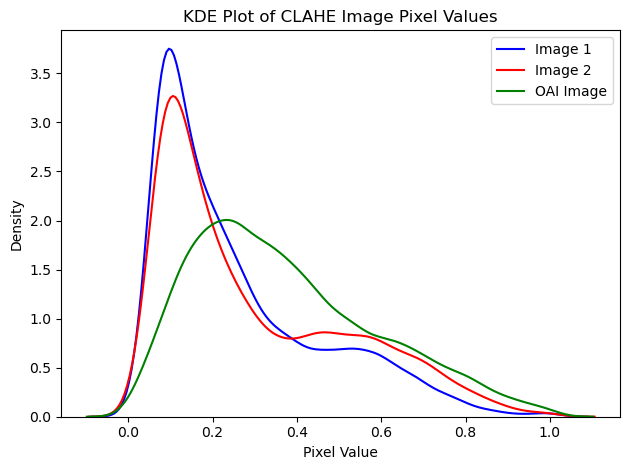

In [53]:
# compare clahe performance on image 1 and 2, and on oai image
echo1, echo2 = get_skmtea_both_echos(image_paths[0], image_dir_path)
image1 = skmtea_crop_im(echo_combination(echo1, echo2))
image1 = clip_and_norm(image1, 0, np.percentile(image1, 99.8)) # remove outliers and scale to 0-1
# clahe
image1_clahe = exposure.equalize_adapthist(image1, clip_limit=0.01, kernel_size=(25, 25, 16))
# plot kde
image1_sample = np.random.choice(image1_clahe.flatten(), size=10000, replace=False)
sns.kdeplot(image1_sample, label='Image 1', color='blue')

echo1, echo2 = get_skmtea_both_echos(image_paths[1], image_dir_path)
image2 = skmtea_crop_im(echo_combination(echo1, echo2))
image2 = clip_and_norm(image2, 0, np.percentile(image2, 99.8)) # remove outliers and scale to 0-1
# clahe
image2_clahe = exposure.equalize_adapthist(image2, clip_limit=0.01, kernel_size=(25, 25, 16))
# plot kde
image2_sample = np.random.choice(image2_clahe.flatten(), size=10000, replace=False)
sns.kdeplot(image2_sample, label='Image 2', color='red')

# clahe the oai image
oai_im = crop_im(oai_array)
oai_im = clip_and_norm(oai_im, 0, np.percentile(oai_im, 99.8))
oai_clahe = exposure.equalize_adapthist(oai_im, clip_limit=0.01, kernel_size=(20, 20, 16))
oai_sample = np.random.choice(oai_clahe.flatten(), size=10000, replace=False)
sns.kdeplot(oai_sample, label='OAI Image', color='green')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of CLAHE Image Pixel Values')
plt.legend()
plt.tight_layout()

plt.show()


/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


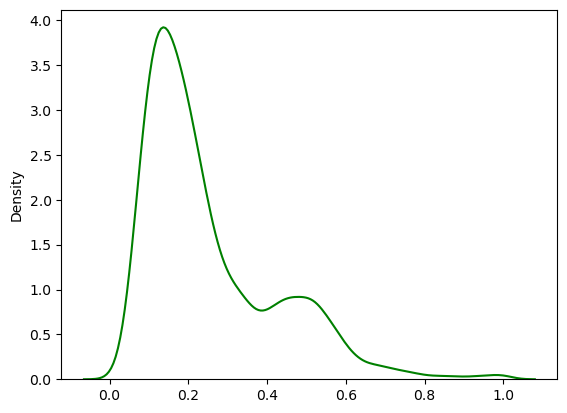

In [5]:
# kde of original oai image
oai_im = crop_im(oai_array)
oai_im = clip_and_norm(oai_im, 0, np.percentile(oai_im, 99.8))
sns.kdeplot(np.random.choice(oai_im.flatten(), size=10000, replace=False), label='OAI Image', color='green')
plt.show()

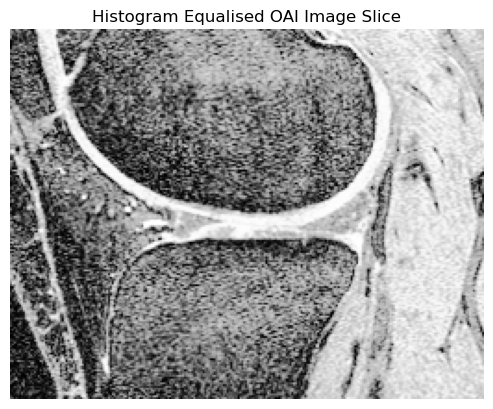

/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


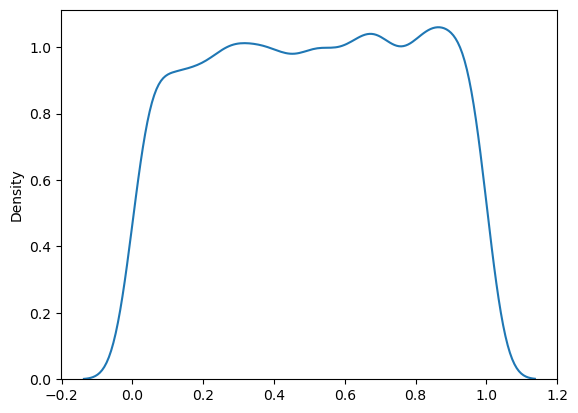

In [6]:
# histogram equalisation on oai_im
oai_eq = exposure.equalize_hist(oai_im)
plt.imshow(oai_eq[..., 100], cmap='gray')
plt.axis('off')
plt.title('Histogram Equalised OAI Image Slice')
plt.show();

# plot histogram of equalised image
eq_sample = np.random.choice(oai_eq.flatten(), size=10000, replace=False)
sns.kdeplot(eq_sample)
plt.show();

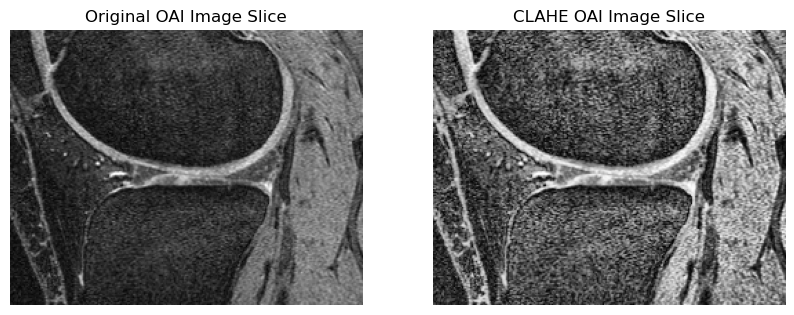

In [55]:
# plot slice of original oai image next to slice of oai post-clahe
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(oai_im[..., 100], cmap='gray')
plt.axis('off')
plt.title('Original OAI Image Slice') 

plt.subplot(1, 2, 2)
plt.imshow(oai_clahe[..., 100], cmap='gray')
plt.axis('off')
plt.title('CLAHE OAI Image Slice')
plt.show();

## Histogram Matching?

/var/folders/pn/qd53v9t55g9c8c6xzhmyl1mh0000gn/T/ipykernel_15094/2665906835.py:2: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_oai = exposure.match_histograms(oai_im, image1_clahe, multichannel=False)
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/olivermills/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

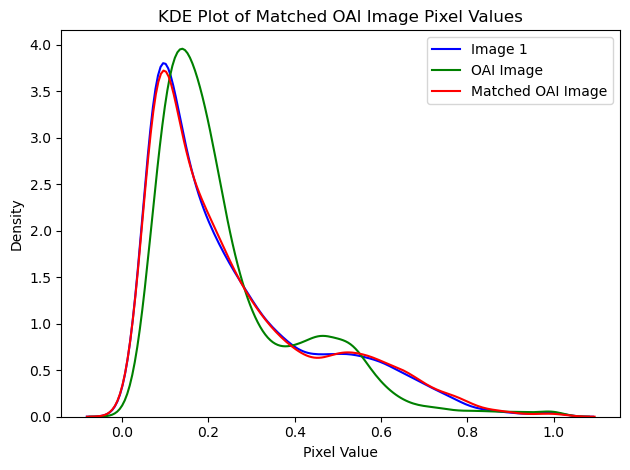

In [58]:
# match histograms
matched_oai = exposure.match_histograms(oai_im, image1_clahe, multichannel=False)

# plot kde of image1, oai image, and matched oai image
image1_sample = np.random.choice(image1_clahe.flatten(), size=10000, replace=False)
sns.kdeplot(image1_sample, label='Image 1', color='blue')

oai_sample = np.random.choice(oai_im.flatten(), size=10000, replace=False)
sns.kdeplot(oai_sample, label='OAI Image', color='green')

matched_sample = np.random.choice(matched_oai.flatten(), size=10000, replace=False)
sns.kdeplot(matched_sample, label='Matched OAI Image', color='red')

plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('KDE Plot of Matched OAI Image Pixel Values')
plt.legend()
plt.tight_layout()

plt.show()

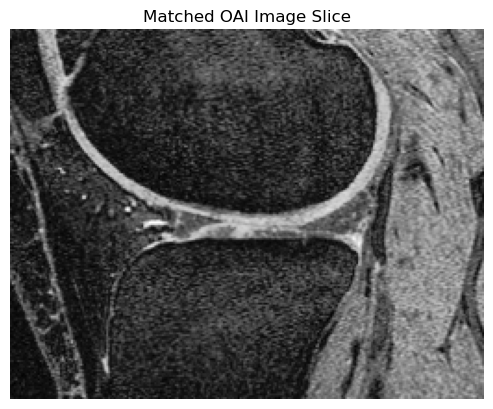

In [59]:
# plot slice of matched oai
plt.imshow(matched_oai[..., 100], cmap='gray')
plt.axis('off')
plt.title('Matched OAI Image Slice')
plt.show();

## Maybe worth looking at where the peak is for the meniscus signal

In [15]:
# load test image and mask
im, mask = get_skmtea_im_and_seg(image_paths[0], image_dir_path)

# crop and clip
im = skmtea_crop_im(im)
im = clip_and_norm(im, 0, np.percentile(im, 99.8))
mask = skmtea_crop_im(mask)

In [16]:
im.shape, mask.shape

((266, 341, 160), (266, 341, 160))

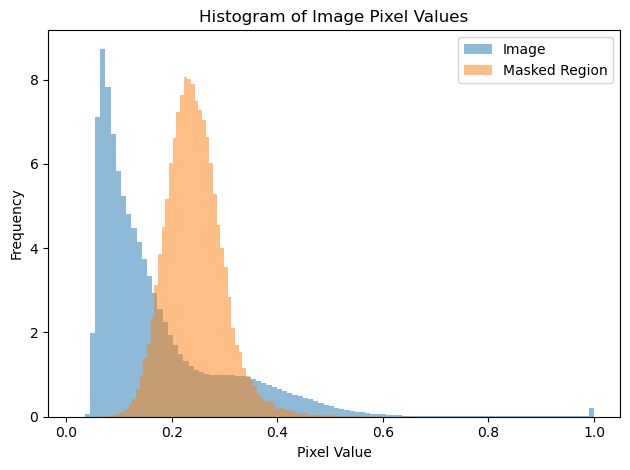

In [25]:
# plot histogram of whole image, and of masked region, log scale
plt.hist(im.flatten(), bins=100, alpha=0.5, label='Image', density=True)
plt.hist(im[mask == 1].flatten(), bins=100, alpha=0.5, label='Masked Region', density=True)

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Image Pixel Values')

plt.legend()
plt.tight_layout()

plt.show()